In [1]:
import json
import time
import random
import pymongo
import copy
import MyCommon
import math
from sets import Set
from pymongo import MongoClient
from collections import deque
import cassiopeia
from cassiopeia import riotapi
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, cluster, decomposition
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import FastICA, PCA
from sklearn import metrics

riotapi.set_region("OCE")
riotapi.set_api_key("79428a9e-5d98-469b-9b9b-429c1a750d24")
riotapi.set_rate_limits((10, 10), (500, 600))
riotapi.print_calls(True)

client = MongoClient()
loladb = client.loladb_zzportal
matches_collection = loladb.matches
print matches_collection.count()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: the sets module is deprecated


15873


In [2]:
def GetWinningSide(a_match):
    winning_side = -1
    if a_match['teams'][0]['winner'] == True and a_match['teams'][1]['winner'] == False:
        winning_side = 0
    if a_match['teams'][0]['winner'] == False and a_match['teams'][1]['winner'] == True:
        winning_side = 1 
    return winning_side

In [3]:
#try to get blue winrate
win_sum = 0
count_sum = 0
for a_idx, a_match in enumerate(matches_collection.find()):
    winning_side = GetWinningSide(a_match)
    win_sum += winning_side
    count_sum += 1
    if a_idx % 1000 == 0:
        print a_idx

print win_sum
print count_sum
print win_sum/float(count_sum)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
7711
15874
0.485762882701


In [4]:
#draw a histogram on interval between kill event
kill_intervals = []
kill_distances = []
kill_pairs = np.zeros((1000000, 2))
kill_index = 0

for a_idx, a_match in enumerate(matches_collection.find()):
    if a_idx%1000 == 0:
        print a_idx
    #print MyCommon.JSONEncoder().encode(a_match)
    #for a_participant in a_match['participants']:
        #print a_participant['stats']['kills']
    kill_num = 0
    prev_kill_frame = 0
    prev_kill_position = None
    frames = a_match['timeline']['frames']
    for a_frame in frames:
        events = a_frame['events']
        for a_event in events:
            if a_event['eventType'] == 'CHAMPION_KILL':
                #print a_event['killerId']
                #print a_event['timestamp']
                if kill_num == 0:
                    prev_kill_frame = int(a_event['timestamp'])
                    prev_kill_position = a_event['position']
                else:
                    current_frame = int(a_event['timestamp'])
                    delta_frame = current_frame - prev_kill_frame
                    kill_intervals.append(delta_frame)
                    
                    current_point = a_event['position']
                    delta_x = current_point['x'] - prev_kill_position['x']
                    delta_y = current_point['y'] - prev_kill_position['y']
                    delta_len = math.sqrt( delta_x**2 + delta_y**2 )
                    kill_distances.append(delta_len)
                    
                    prev_kill_frame = current_frame
                    prev_kill_position = current_point
                    
                    kill_pairs[kill_index, 0] = delta_frame
                    kill_pairs[kill_index, 1] = delta_len
                    kill_index += 1
                kill_num += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


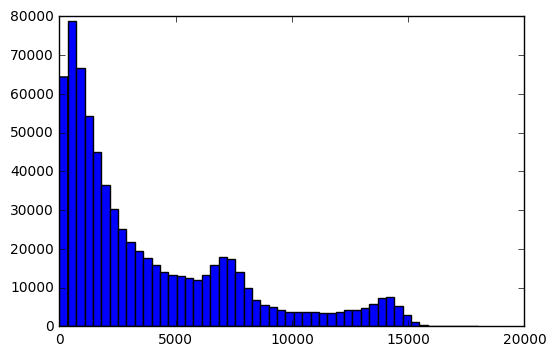

In [5]:
plt.hist(kill_distances, bins=50)
plt.show()

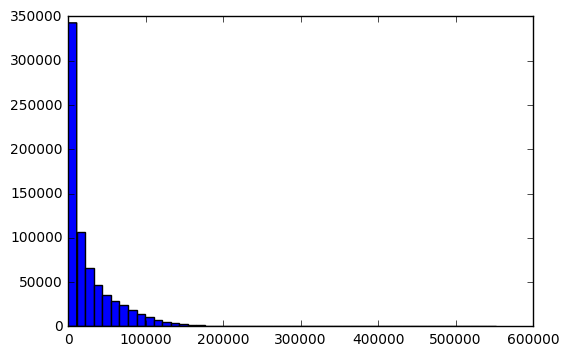

In [6]:
plt.hist(kill_intervals, bins=50)
plt.show()

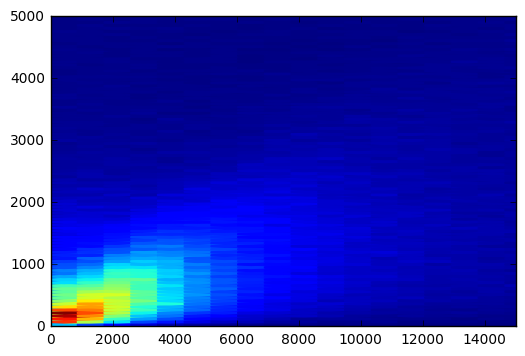

In [7]:
data_size = len(kill_intervals)
plt.hexbin(kill_pairs[0:data_size, 0],kill_pairs[0:data_size, 1], gridsize=640)
plt.axis([0, 15000, 0, 5000])
plt.show()

In [12]:
#another round of stats
#if we use dt = 10s and ds == 2000
#get histogram on (kill_num, timestamp, involve_num = killer + victim + assistants)
#see if there's a gap between laning kill/duel kill/group kill
dt = 15000
ds = 3000

fight_kill_num = 0
fight_blue_die_num = 0
fight_red_die_num = 0
fight_start_time = 0
fight_blue_involves = Set()
fight_red_involves = Set()
blue_team_with_portal = Set()
red_team_with_portal = Set()

portal_adv_num = 0
portal_unrelated_num = 0
portal_adv_turret_num = 0
portal_unrelated_turret_num = 0
blue_selfdestruct_turret = 0
red_selfdestruct_turret = 0

portal_purchase_leading = 0
portal_purchase_leading_sum = 0
portal_purchase_time = 0
portal_purchase_time_sum = 0
portal_purchase_num = 0
portal_purchase_win = 0

#kill_events = []
fight_events = []
win_events = []

champ_portal_num = {}
champ_portal_win = {}
portal_game_num = 0

for a_idx, a_match in enumerate(matches_collection.find()):
    if a_idx%1000 == 0:
        print a_idx
    #print MyCommon.JSONEncoder().encode(a_match)
    #for a_participant in a_match['participants']:
        #print a_participant['stats']['kills']
    kill_num = 0
    prev_kill_frame = 0
    prev_kill_position = None
    
    fight_kill_num = 0
    fight_blue_die_num = 0
    fight_red_die_num = 0
    fight_start_time = 0
    fight_blue_involves.clear()
    fight_red_involves.clear()
    blue_team_with_portal.clear()
    red_team_with_portal.clear()
    blue_selfdestruct_turret = 0
    red_selfdestruct_turret = 0
    
    portal_purchase_leading = 0
    portal_purchase_time = 0
    
    frames = a_match['timeline']['frames']
    for a_frame_idx,a_frame in enumerate(frames):
        events = a_frame['events']
        for a_event in events:
            if a_event['eventType'] == 'ITEM_PURCHASED':
                if int(a_event['itemId']) == 3512:#3041:#杀人书， 传送门3512:
                    #a portal is purchased
                    purchase_champ = a_match['participants'][a_event['participantId'] - 1]['championId']
                    #print a_event['eventType']
                    #print purchase_champ
                    if int(a_event['participantId']) <= 5:
                        blue_team_with_portal.add(purchase_champ)
                    else:
                        red_team_with_portal.add(purchase_champ)
                        
                    #calculate the difference between portal owner team to another
                    if portal_purchase_leading == 0:
                        portal_purchase_time = a_frame_idx
                        blue_gold = 0
                        red_gold = 0
                        participantFrames = a_frame['participantFrames']

                        for i_team_idx in range(5):
                            blue_gold += participantFrames[str(i_team_idx + 1)]['totalGold']
                            red_gold += participantFrames[str(i_team_idx + 6)]['totalGold']
                            
                        if int(a_event['participantId']) <= 5:
                            portal_purchase_leading = blue_gold - red_gold
                        else:
                            portal_purchase_leading = red_gold - blue_gold
                        
            if a_event['eventType'] == 'ITEM_SOLD' or a_event['eventType'] == 'ITEM_UNDO':
                if int(a_event['itemId']) == 3512:
                    #a portal is sold or undo
                    purchase_champ = a_match['participants'][a_event['participantId'] - 1]['championId']
                    #print a_event['eventType']
                    #print purchase_champ
                    if int(a_event['participantId']) <= 5:
                        blue_team_with_portal.discard(purchase_champ)
                    else:
                        red_team_with_portal.discard(purchase_champ)
                        
            if a_event['eventType'] == 'BUILDING_KILL':
                if a_event['killerId'] == 0:
                    posx = a_event['position']['x']
                    posy = a_event['position']['y']
                    if posx + posy > 14000:
                        #red
                        red_selfdestruct_turret += 1
                    else:
                        #blue
                        blue_selfdestruct_turret += 1
                        
            if a_event['eventType'] == 'CHAMPION_KILL':
                #print a_event['killerId']
                #print a_event['timestamp']
                #kill_events.append(a_event)
                fight_kill_num += 1
                if fight_kill_num == 1:
                    fight_start_time = int(a_event['timestamp'])
                    
                if int(a_event['victimId']) <= 5:
                    fight_blue_die_num += 1
                    fight_blue_involves.add(int(a_event['victimId']))
                    #for killer and assists
                    fight_red_involves.add(int(a_event['killerId']))
                    for assistId in a_event['assistingParticipantIds']:
                        fight_red_involves.add(int(assistId))
                else:
                    fight_red_die_num += 1
                    fight_red_involves.add(int(a_event['victimId']))
                    #for killer and assists
                    fight_blue_involves.add(int(a_event['killerId']))
                    for assistId in a_event['assistingParticipantIds']:
                        fight_blue_involves.add(int(assistId))
                    
                if kill_num == 0:
                    prev_kill_frame = int(a_event['timestamp'])
                    prev_kill_position = a_event['position']
                else:
                    current_frame = int(a_event['timestamp'])
                    delta_frame = current_frame - prev_kill_frame
                    #kill_intervals.append(delta_frame)
                    
                    current_point = a_event['position']
                    delta_x = current_point['x'] - prev_kill_position['x']
                    delta_y = current_point['y'] - prev_kill_position['y']
                    delta_len = math.sqrt( delta_x**2 + delta_y**2 )
                    #kill_distances.append(delta_len)
                    
                    prev_kill_frame = current_frame
                    prev_kill_position = current_point
                    
                    if delta_frame < dt and delta_len < ds:
                        #fight continues
                        abc = 0
                    else:
                        #prev fight already done
                        #reset
                        #record prev data
                        #print fight_kill_num
                        #print fight_blue_die_num, fight_red_die_num, fight_start_time
                        #print len(fight_blue_involves), len(fight_red_involves)
                        #print blue_portal_num, red_portal_num
                        #print "END"
                        #在这里记录团战事件
                        fight_events.append({'blue_die':fight_blue_die_num, 
                                            'red_die':fight_red_die_num,
                                            'blue_num':len(fight_blue_involves),
                                            'red_num':len(fight_red_involves),
                                            'blue_portal':len(blue_team_with_portal),
                                            'red_portal':len(red_team_with_portal)})
                        fight_kill_num = 0
                        fight_blue_die_num = 0
                        fight_red_die_num = 0
                        fight_start_time = 0
                        fight_blue_involves.clear()
                        fight_red_involves.clear()
                
                kill_num += 1
    
    if fight_kill_num != 0:
        #record it
        #在这里记录团战事件
        fight_events.append({'blue_die':fight_blue_die_num, 
                    'red_die':fight_red_die_num,
                    'blue_num':len(fight_blue_involves),
                    'red_num':len(fight_red_involves),
                    'blue_portal':len(blue_team_with_portal),
                    'red_portal':len(red_team_with_portal)})
        #print fight_kill_num
        #print fight_blue_die_num, fight_red_die_num, fight_start_time
        #print len(fight_blue_involves), len(fight_red_involves)
        #print blue_portal_num, red_portal_num
        #print "END"
        
    #在这里记录胜负
    win_events.append({'win_side':GetWinningSide(a_match), 
            'blue_portal':len(blue_team_with_portal),
            'red_portal':len(red_team_with_portal)})
    
    if len(blue_team_with_portal) + len(red_team_with_portal) == 1:
        portal_purchase_time_sum += portal_purchase_time
        portal_purchase_leading_sum += portal_purchase_leading
        portal_purchase_num += 1
        if len(blue_team_with_portal) > len(red_team_with_portal) and GetWinningSide(a_match) == 0:
            portal_purchase_win += 1
        if len(blue_team_with_portal) < len(red_team_with_portal) and GetWinningSide(a_match) == 1:
            portal_purchase_win += 1
    
    if len(blue_team_with_portal) > 0 or len(red_team_with_portal) > 0:
        portal_game_num += 1
        
    if len(blue_team_with_portal) != len(red_team_with_portal):
        portal_adv_num += 1
        if len(blue_team_with_portal) > len(red_team_with_portal):
            portal_adv_turret_num += blue_selfdestruct_turret
        else:
            portal_adv_turret_num += red_selfdestruct_turret
    else:
        portal_unrelated_num += 1
        portal_unrelated_turret_num += blue_selfdestruct_turret
        portal_unrelated_turret_num += red_selfdestruct_turret

    for a_blue in blue_team_with_portal:
        if a_blue in champ_portal_num.keys():
            champ_portal_num[a_blue] += 1
        else:
            champ_portal_num[a_blue] = 1
            
        if GetWinningSide(a_match) == 0:
            if a_blue in champ_portal_win.keys():
                champ_portal_win[a_blue] += 1
            else:
                champ_portal_win[a_blue] = 1 
                
    for a_red in red_team_with_portal:
        if a_red in champ_portal_num.keys():
            champ_portal_num[a_red] += 1
        else:
            champ_portal_num[a_red] = 1
            
        if GetWinningSide(a_match) == 1:
            if a_red in champ_portal_win.keys():
                champ_portal_win[a_red] += 1
            else:
                champ_portal_win[a_red] = 1 

print portal_game_num

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
3161


In [13]:
print portal_purchase_leading_sum / float(portal_purchase_num)
print portal_purchase_win / float(portal_purchase_num)
print portal_purchase_time_sum / float(portal_purchase_num)

375.791666667
0.556327160494
26.6601080247


In [44]:
print portal_adv_turret_num/float(portal_adv_num), (portal_unrelated_turret_num/2.0)/float(portal_unrelated_num)
print portal_adv_num, portal_unrelated_num

1.46519721578 1.4664165277
2586 10794


In [49]:
print champ_portal_num

champions = riotapi.get_champions()
dict_id2idx = dict()
dict_idx2id = dict()
dict_id2key = dict()
for a_idx, a_champion in enumerate(champions):
    champ_id = a_champion.id
    champ_key = a_champion.key
    dict_id2idx[champ_id] = a_idx
    dict_idx2id[a_idx] = champ_id
    dict_id2key[champ_id] = champ_key
    
#print dict_id2key[dict_idx2id[132]]
#print dict_id2key

def GetIdxFromId(a_id):
    return dict_id2idx[a_id]

def GetIdFromIdx(a_idx):
    return dict_idx2id[a_idx]

def GetNameFromId(a_id):
    return dict_id2key[a_id]

champ_portal_rate = {}
for a_key in champ_portal_num:
    win_num = 0
    if a_key in champ_portal_win.keys():
        win_num = champ_portal_win[a_key]

    rate = win_num/float(champ_portal_num[a_key])
    champ_portal_rate[a_key] = rate
    
from operator import itemgetter
sorted_rate = sorted(champ_portal_rate.items(), key=itemgetter(1))

for a_key, a_value in sorted_rate:
    if champ_portal_num[a_key] > 50:
        print a_key
        print GetNameFromId(a_key), a_value, champ_portal_num[a_key]

{1: 7, 2: 21, 3: 9, 4: 3, 5: 10, 6: 2, 7: 3, 8: 1, 9: 2, 10: 1, 11: 8, 12: 106, 13: 5, 14: 112, 16: 59, 17: 73, 19: 3, 20: 18, 21: 2, 22: 2, 23: 16, 24: 8, 25: 50, 26: 16, 27: 365, 28: 3, 30: 3, 31: 23, 32: 27, 33: 45, 34: 8, 35: 29, 36: 36, 37: 24, 39: 9, 40: 35, 41: 7, 43: 36, 44: 10, 45: 15, 48: 16, 50: 6, 51: 2, 53: 127, 54: 87, 55: 1, 56: 4, 57: 32, 58: 21, 59: 18, 60: 8, 62: 8, 63: 9, 64: 59, 67: 4, 68: 10, 69: 5, 72: 2, 74: 80, 75: 188, 76: 5, 77: 89, 78: 84, 79: 7, 80: 19, 82: 8, 83: 172, 84: 5, 85: 3, 86: 60, 89: 68, 90: 21, 91: 3, 92: 8, 98: 59, 99: 13, 101: 1, 102: 18, 103: 4, 105: 2, 106: 17, 107: 3, 111: 140, 113: 11, 114: 7, 115: 8, 117: 19, 119: 2, 120: 18, 121: 5, 122: 135, 126: 4, 127: 2, 134: 2, 136: 2, 143: 26, 150: 9, 154: 34, 157: 8, 161: 6, 163: 5, 164: 14, 201: 57, 202: 3, 203: 1, 223: 44, 236: 1, 238: 2, 240: 5, 245: 13, 254: 20, 266: 1, 267: 30, 412: 188, 420: 15, 421: 9, 427: 47, 432: 45}
64
LeeSin 0.423728813559 59
98
Shen 0.423728813559 59
78
Poppy 0.5 84
20

In [45]:
#分析传送门对最终胜率的影响

more_portal_num = 0
more_portal_win = 0
more_1_num = 0
more_2_num = 0
more_3_num = 0
more_1_win = 0
more_2_win = 0
more_3_win = 0

for event in win_events:
    portal_delta = event['blue_portal'] - event['red_portal']
    
    if event['blue_portal'] > event['red_portal']:
        #print event
        more_portal_num += 1
        if event['win_side'] == 0:
            more_portal_win += 1
        if portal_delta == 1:
            more_1_num += 1
            if event['win_side'] == 0:
                more_1_win += 1
        if portal_delta == 2:
            more_2_num += 1
            if event['win_side'] == 0:
                more_2_win += 1
        if portal_delta == 3:
            more_3_num += 1
            if event['win_side'] == 0:
                more_3_win += 1
                
    if event['blue_portal'] < event['red_portal']:
        #print event
        more_portal_num += 1
        if event['win_side'] == 1:
            more_portal_win += 1
        if portal_delta == -1:
            more_1_num += 1
            if event['win_side'] == 1:
                more_1_win += 1
        if portal_delta == -2:
            more_2_num += 1
            if event['win_side'] == 1:
                more_2_win += 1
        if portal_delta == -3:
            more_3_num += 1
            if event['win_side'] == 1:
                more_3_win += 1
                
print more_portal_win, more_portal_num
print more_portal_win / float(more_portal_num)
print more_1_win / float(more_1_num)
print more_2_win / float(more_2_num)
print more_3_win / float(more_3_num)

1433 2586
0.554137664346
0.556572379368
0.517441860465
0.6


In [46]:
print more_1_num, more_2_num, more_3_num

2404 172 10


In [47]:
#分析传送门对团战胜率的影响
more_portal_num = 0
more_portal_more_pp = 0
more_portal_same_pp = 0
more_portal_less_pp = 0
more_portal_win = 0
more_portal_draw = 0
more_portal_lose = 0

total_events = len(fight_events)
for a_idx, event in enumerate(fight_events):
    #print event
    portal_delta = event['blue_portal'] - event['red_portal']
    die_delta = event['blue_die'] - event['red_die']
    num_delta = event['blue_num'] - event['red_num']
    if portal_delta > 0:
        more_portal_num += 1
        if die_delta < 0:
            more_portal_win += 1
        elif die_delta == 0:
            more_portal_draw += 1
        elif die_delta > 0:
            more_portal_lose += 1
            
        if num_delta > 0:
            more_portal_more_pp += 1
        elif num_delta < 0:
            more_portal_less_pp += 1
        elif num_delta == 0:
            more_portal_same_pp += 1
            
    if portal_delta < 0:
        more_portal_num += 1
        if die_delta > 0:
            more_portal_win += 1
        elif die_delta == 0:
            more_portal_draw += 1
        elif die_delta < 0:
            more_portal_lose += 1
            
        if num_delta < 0:
            more_portal_more_pp += 1
        elif num_delta > 0:
            more_portal_less_pp += 1
        elif num_delta == 0:
            more_portal_same_pp += 1

print more_portal_num
print more_portal_more_pp, more_portal_same_pp, more_portal_less_pp
print more_portal_win, more_portal_draw, more_portal_lose

36250
13567 9252 13431
16065 4303 15882


In [50]:
#具体每个英雄出传送门的胜率

1872
51
3253


In [12]:
#传送门胜率与段位的关系
print a_match

{u'participantIdentities': [{u'player': None, u'participantId': 1}, {u'player': None, u'participantId': 2}, {u'player': None, u'participantId': 3}, {u'player': None, u'participantId': 4}, {u'player': None, u'participantId': 5}, {u'player': None, u'participantId': 6}, {u'player': None, u'participantId': 7}, {u'player': None, u'participantId': 8}, {u'player': None, u'participantId': 9}, {u'player': None, u'participantId': 10}], u'matchVersion': u'6.24.169.4424', u'platformId': u'OC1', u'season': u'PRESEASON2017', u'region': u'OCE', u'matchId': 159211939, u'mapId': 11, u'matchCreation': 1482965139708L, u'teams': [{u'firstDragon': False, u'firstInhibitor': False, u'bans': [], u'baronKills': 0, u'firstRiftHerald': False, u'winner': False, u'firstBaron': False, u'riftHeraldKills': 0, u'firstBlood': False, u'teamId': 100, u'firstTower': False, u'vilemawKills': 0, u'inhibitorKills': 0, u'towerKills': 1, u'dominionVictoryScore': 0, u'dragonKills': 0}, {u'firstDragon': True, u'firstInhibitor': F

In [32]:
print portal_game_num/13379.0

0.21541221317
